In [2]:
import argparse
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
import kerastuner as kt
from kerastuner.tuners import Hyperband

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.alphabet import ALPHABET_DNA, ALPHABET_PROTEIN
from rna_learn.transform import (
    sequence_embedding, 
    normalize, denormalize,
    one_hot_encode_classes,
    split_train_test_set,
    combine_sequences,
)
from rna_learn.hyperband import hyperband_densenet_model

In [3]:
sns.set(palette='colorblind', font_scale=1.3)

In [4]:
hyperband_run_id = 'protein_4gtcy'

build_model_fn = hyperband_densenet_model(n_inputs=len(ALPHABET_PROTEIN))

hypermodel = Hyperband(
    build_model_fn,
    max_epochs=200,
    objective=kt.Objective('val_loss', 'min'),
    factor=3,
    hyperband_iterations=1,
    project_name=f'hyperband_logs/{hyperband_run_id}',
)

INFO:tensorflow:Reloading Oracle from existing project ./hyperband_logs/protein_4gtcy/oracle.json
INFO:tensorflow:Reloading Tuner from ./hyperband_logs/protein_4gtcy/tuner0.json


In [9]:
best_hyperparameters_sets = hypermodel.get_best_hyperparameters()

In [10]:
best_hyperparameters = best_hyperparameters_sets[0]

In [12]:
best_hyperparameters.values

{'n_layers': 14,
 'growth_rate': 14,
 'l2_reg_conv': 1e-05,
 'l2_reg_mean_std': 1e-05,
 'learning_rate': 0.0005,
 'kernel_size_l1': 2,
 'kernel_size_l2': 3,
 'kernel_size_l3': 5,
 'kernel_size_l4': 4,
 'kernel_size_l5': 3,
 'kernel_size_l6': 3,
 'kernel_size_l7': 3,
 'kernel_size_l8': 3,
 'kernel_size_l9': 3,
 'kernel_size_l10': 5,
 'kernel_size_l11': 4,
 'kernel_size_l12': 4,
 'kernel_size_l13': 3,
 'kernel_size_l14': 3,
 'kernel_size_l15': 4,
 'kernel_size_l16': 5,
 'kernel_size_l17': 5,
 'kernel_size_l18': 5,
 'kernel_size_l19': 3,
 'kernel_size_l20': 3,
 'tuner/epochs': 67,
 'tuner/initial_epoch': 23,
 'tuner/bracket': 2,
 'tuner/round': 1,
 'tuner/trial_id': '2e24aa8caad2bcf505ca5cbbb899285d'}

In [13]:
best_model = hypermodel.get_best_models(1)[0]

In [17]:
train_set_path = os.path.join(os.getcwd(), 'data/gtdb/dataset_test.csv')
test_set_path = os.path.join(os.getcwd(), 'data/gtdb/dataset_test.csv')

train_df = pd.read_csv(train_set_path)
dataset_df = pd.read_csv(test_set_path)

In [18]:
y_train = train_df['temperature'].values.astype('float64')
mean, std = np.mean(y_train), np.std(y_train)

dna_sequences = dataset_df['mrna_candidate_sequence'].values
protein_sequences = dataset_df['amino_acid_sequence'].values

x_protein = sequence_embedding(protein_sequences, ALPHABET_PROTEIN, dtype='float32')
y = dataset_df['temperature'].values.astype('float32')
y_norm = normalize(y, mean, std)

In [20]:
%%time
best_model.evaluate(x_protein, y_norm, verbose=0)

CPU times: user 3.75 s, sys: 485 ms, total: 4.23 s
Wall time: 1.25 s


1.1901252973296665

In [21]:
y_hat = best_model(x_protein)
y_mean = denormalize(y_hat.mean().numpy(), mean, std)
y_std = denormalize(y_hat.stddev().numpy(), mean, std)

In [22]:
mae = np.mean(np.abs(y_mean.flatten() - y))
rmse = np.sqrt(np.mean((y_mean.flatten() - y) **2))
correlation = np.corrcoef(y, y_mean.flatten())[0, 1]

print(f'Mean Absolute Error    = {mae:.2f}')
print(f'Root Mean Square Error = {rmse:.2f}')
print(f'Correlation            = {correlation:.2f}')

Mean Absolute Error    = 10.35
Root Mean Square Error = 13.26
Correlation            = 0.61


In [23]:
def predictions_per_specie(dataset_df, y_true, y_pred):
    y_species_pred = []
    y_species_actual = []
    
    sequence_ids = sorted(dataset_df['gtdb_genome_representative'].unique().tolist())
    for sequence_id in sequence_ids:
        indices = dataset_df[dataset_df['gtdb_genome_representative'] == sequence_id].index
        
        truth = y_true[indices[0]]
        prediction = np.mean(y_pred[indices])
        
        y_species_actual.append(truth)
        y_species_pred.append(prediction)
    
    return np.array(y_species_actual), np.array(y_species_pred)

In [24]:
def plot_true_vs_prediction_per_specie(y_true, y_pred):
    f, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    palette = sns.color_palette()
    
    x_straight = range(0, 80)
    ax.plot(x_straight, x_straight, '--', color=palette[1], linewidth=2)
    
    for i in range(len(y_true)):
        y_t = y_true[i]
        y_p = y_pred[i]
        ax.plot(y_t, y_p, 'o', color=palette[0])
    
    ax.set_xlim(0, 80)
    ax.set_ylim(0, 80)
    ax.set_xlabel('Temperature °C (truth)')
    ax.set_ylabel('Temperature °C (prediction)')
    return f, ax

In [25]:
y_species_actual, y_species_pred = predictions_per_specie(dataset_df, y, y_mean)

In [26]:
mae_species = np.mean(np.abs(y_species_pred.flatten() - y_species_actual))
rmse_species = np.sqrt(np.mean((y_species_pred.flatten() - y_species_actual) **2))
corr_species = np.corrcoef(y_species_actual, y_species_pred.flatten())[0, 1]

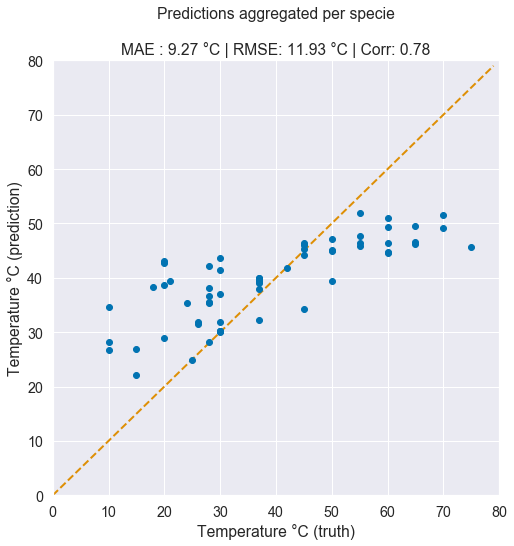

In [27]:
f, ax = plot_true_vs_prediction_per_specie(y_species_actual, y_species_pred);
title = f'Predictions aggregated per specie\n\n'
title += f'MAE : {mae_species:.2f} °C | '
title += f'RMSE: {rmse_species:.2f} °C | '
title += f'Corr: {corr_species:.2f}'
ax.set_title(title);